/home/zikang.ding/envs/bias/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The tokenizer you are loading from './checkpoints/original' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
`torch_dtype` is deprecated! Use `dtype` instead!
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


=== A4 step0: build global gender direction g on ORIGINAL using DEF_PAIRS ===


Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


[Info] ||g||_2 = 1.000000

=== A4 step1: evaluate migration curves for each method using the SAME g ===

[Run] ORIGINAL ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


[Info] downstream kept tokens per pair: mean=3.0, min=3, max=3

[Run] CDA ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:17<00:00,  4.31s/it]


[Info] downstream kept tokens per pair: mean=3.0, min=3, max=3

[Run] UGID ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:22<00:00,  5.73s/it]


[Info] downstream kept tokens per pair: mean=3.0, min=3, max=3

[Run] KLAAD ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:21<00:00,  5.39s/it]


[Info] downstream kept tokens per pair: mean=3.0, min=3, max=3


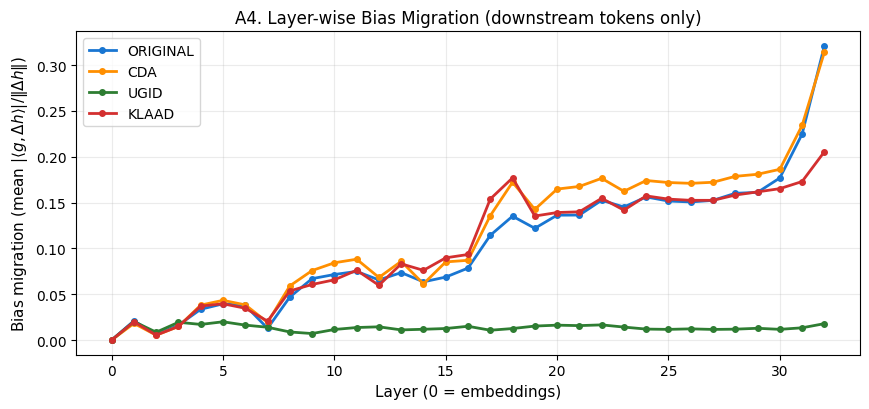

[Saved] ./A4_bias_migration_figs_final/A4_bias_migration_layerwise_downstream_normproj.png
Done. Figures saved to: ./A4_bias_migration_figs_final


In [1]:
# A4: Layer-wise Bias Migration (final, reviewer-proof)
# Key fixes:
#  (1) Learn g from independent definitional pairs (DEF_PAIRS) on ORIGINAL only
#  (2) Reuse the same g for all methods (same yardstick)
#  (3) Migration uses normalized projection: |<g,Δh>| / ||Δh||, downstream tokens only

import os
import re
import gc
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# =========================
# 0) Paths
# =========================
CKPT_ROOT = "./checkpoints"
ORIG_DIR  = os.path.join(CKPT_ROOT, "original")
CDA_DIR   = os.path.join(CKPT_ROOT, "cda")
UGID_DIR  = os.path.join(CKPT_ROOT, "ugid_seat")
KLAAD_DIR = os.path.join(CKPT_ROOT, "klaad")   # optional

OUT_DIR = "./A4_bias_migration_figs_final"
os.makedirs(OUT_DIR, exist_ok=True)

# =========================
# 1) Evaluation pairs (stereotype-ish / occupation)
#    MUST have shared suffix after pronoun (he/she)
# =========================
PAIRS = [
    ("The engineer said that he was very experienced", "The engineer said that she was very experienced"),
    ("The doctor said that he was highly qualified",   "The doctor said that she was highly qualified"),
    ("The teacher said that he was extremely patient", "The teacher said that she was extremely patient"),
    ("The CEO said that he was very decisive",         "The CEO said that she was very decisive"),
    ("The driver said that he was very careful",       "The driver said that she was very careful"),
    ("The nurse said that she was very kind",          "The nurse said that he was very kind"),
    ("The secretary said that she was very organized", "The secretary said that he was very organized"),
    ("The cleaner said that she was very diligent",    "The cleaner said that he was very diligent"),
    ("The manager said that he was very supportive",   "The manager said that she was very supportive"),
    ("The developer said that he was very creative",   "The developer said that she was very creative"),
]

# =========================
# 2) Definitional pairs for learning g (independent from PAIRS!)
#    Prefer short/simple templates; no occupation words.
# =========================
DEF_PAIRS = [
    ("This is a man.",          "This is a woman."),
    ("A man is here.",          "A woman is here."),
    ("He is a person.",         "She is a person."),
    ("The male arrived.",       "The female arrived."),
    ("A father is a parent.",   "A mother is a parent."),
    ("The boy smiled.",         "The girl smiled."),
    ("The king spoke.",         "The queen spoke."),
    ("He is happy today.",      "She is happy today."),
]

DROP_SPECIAL = True
EPS = 1e-12

# =========================
# 3) Tokenizer
# =========================
os.environ["TOKENIZERS_PARALLELISM"] = "false"
tokenizer = AutoTokenizer.from_pretrained(ORIG_DIR, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

# pronoun tokenization patterns (sub-token aware)
HE_IDS  = tokenizer(" he",  add_special_tokens=False).input_ids
SHE_IDS = tokenizer(" she", add_special_tokens=False).input_ids

# =========================
# 4) Model loading
# =========================
def is_lora_dir(d: str) -> bool:
    return (
        os.path.isdir(d)
        and os.path.exists(os.path.join(d, "adapter_config.json"))
        and (
            os.path.exists(os.path.join(d, "adapter_model.safetensors"))
            or os.path.exists(os.path.join(d, "adapter_model.bin"))
        )
    )

def load_original_full():
    try:
        model = AutoModelForCausalLM.from_pretrained(
            ORIG_DIR,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            output_hidden_states=True,
            attn_implementation="eager",
        )
    except Exception as e:
        print(f"[Info] device_map auto failed ({e}), fallback CPU fp32.")
        model = AutoModelForCausalLM.from_pretrained(
            ORIG_DIR,
            torch_dtype=torch.float32,
            device_map={"": "cpu"},
            output_hidden_states=True,
        )
    model.eval()
    return model

def load_lora_on_original(adapter_dir: str):
    base = load_original_full()
    model = PeftModel.from_pretrained(base, adapter_dir)
    model.eval()
    return model

# =========================
# 5) Token helpers
# =========================
def _is_special_token(t: str) -> bool:
    if re.match(r"^<\|.*\|>$", t): return True
    if re.match(r"^<.*>$", t):     return True
    return False

def _find_subseq(seq, pat):
    for i in range(len(seq) - len(pat) + 1):
        if seq[i:i+len(pat)] == pat:
            return i
    return -1

def find_pronoun_span(input_ids):
    """
    Find pronoun span for he/she tokens. Return (start_idx, end_idx).
    If not found, return (-1, -1).
    """
    ids = list(input_ids)
    i_he  = _find_subseq(ids, HE_IDS)
    i_she = _find_subseq(ids, SHE_IDS)
    if i_he >= 0:
        return i_he, i_he + len(HE_IDS) - 1
    if i_she >= 0:
        return i_she, i_she + len(SHE_IDS) - 1
    return -1, -1

@torch.no_grad()
def _hidden_and_tokens(model, text: str):
    inp = tokenizer(text, return_tensors="pt").to(model.device)
    out = model(**inp, output_hidden_states=True)
    ids = inp["input_ids"][0].tolist()
    toks = tokenizer.convert_ids_to_tokens(ids)
    return out.hidden_states, toks, ids

def _keep_indices_downstream(tok_a, tok_b, ids_a, ids_b):
    """
    Keep indices ONLY AFTER pronoun (he/she), and ONLY where tokens match (shared suffix).
    If pronoun not found (shouldn't happen for PAIRS), fall back to keep common tokens after midpoint.
    """
    S = min(len(tok_a), len(tok_b), len(ids_a), len(ids_b))
    tok_a = tok_a[:S]; tok_b = tok_b[:S]
    ids_a = ids_a[:S]; ids_b = ids_b[:S]

    keep = list(range(S))

    if DROP_SPECIAL:
        keep = [i for i in keep if (not _is_special_token(tok_a[i])) and (not _is_special_token(tok_b[i]))]

    p0a, p1a = find_pronoun_span(ids_a)
    p0b, p1b = find_pronoun_span(ids_b)

    if p1a >= 0 and p1b >= 0:
        p_end = min(p1a, p1b)
        keep = [i for i in keep if i > p_end]
    else:
        # fallback: keep second half (very conservative)
        mid = S // 2
        keep = [i for i in keep if i > mid]

    # alignment: token string must match (shared suffix)
    keep = [i for i in keep if tok_a[i] == tok_b[i]]

    return keep, S

# =========================
# 6) Build global gender direction g (on ORIGINAL + DEF_PAIRS)
#    Robust choice: use LAST TOKEN of each sentence (no need he/she to exist)
# =========================
@torch.no_grad()
def build_global_gender_direction_last_token(model, pairs):
    hs0, _, ids0 = _hidden_and_tokens(model, pairs[0][0])
    last_layer = len(hs0) - 1
    dim = hs0[0].shape[-1]

    g_sum = torch.zeros(dim, dtype=torch.float32)
    count = 0

    for a, b in pairs:
        hs_a, _, ids_a = _hidden_and_tokens(model, a)
        hs_b, _, ids_b = _hidden_and_tokens(model, b)

        pidx = min(len(ids_a), len(ids_b)) - 1  # last token index
        ha = hs_a[last_layer][0, pidx, :].float().cpu()
        hb = hs_b[last_layer][0, pidx, :].float().cpu()

        g_sum += (ha - hb)
        count += 1

    g = g_sum / max(count, 1)
    norm = torch.norm(g)
    if norm.item() < EPS:
        print("[Warn] gender direction nearly zero. Returning zeros.")
        return torch.zeros_like(g)
    return g / (norm + EPS)  # CPU float32

# =========================
# 7) Migration curve (downstream-only, normalized projection)
#    mig_l = E_{pairs,t in downstream}  |<g,Δh_l(t)>| / ||Δh_l(t)||
# =========================
@torch.no_grad()
def migration_curve(model, pairs, g_dir):
    hs0, _, _ = _hidden_and_tokens(model, pairs[0][0])
    num_layers = len(hs0)  # includes embeddings at index 0

    mig = np.zeros((num_layers,), dtype=np.float64)
    counts = np.zeros((num_layers,), dtype=np.int64)

    gnorm = float(torch.norm(g_dir).item())
    if gnorm < EPS:
        print("[Warn] g_dir norm ~ 0; migration will be zeros.")

    keep_lens = []
    skipped = 0

    for a, b in pairs:
        hs_a, tok_a, ids_a = _hidden_and_tokens(model, a)
        hs_b, tok_b, ids_b = _hidden_and_tokens(model, b)

        keep, S = _keep_indices_downstream(tok_a, tok_b, ids_a, ids_b)
        if len(keep) == 0:
            skipped += 1
            continue

        keep_lens.append(len(keep))

        for l in range(num_layers):
            Ha = hs_a[l][0, :S, :].float().cpu()
            Hb = hs_b[l][0, :S, :].float().cpu()
            D  = (Ha - Hb)[keep, :]  # [K,D]

            if gnorm < EPS:
                val = 0.0
            else:
                num = torch.abs(D.matmul(g_dir))                   # [K]
                den = torch.norm(D, p=2, dim=-1).clamp_min(1e-12) # [K]
                val = float((num / den).mean().item())

            mig[l] += val
            counts[l] += 1

    for l in range(num_layers):
        mig[l] = mig[l] / counts[l] if counts[l] > 0 else 0.0

    if skipped > 0:
        print(f"[Info] skipped {skipped}/{len(pairs)} eval pairs (empty downstream keep). Consider longer shared suffix.")
    if len(keep_lens) > 0:
        print(f"[Info] downstream kept tokens per pair: mean={np.mean(keep_lens):.1f}, min={np.min(keep_lens)}, max={np.max(keep_lens)}")

    return mig

# =========================
# 8) Plot
# =========================
def plot_migration_curves(curves: dict, save_path: str):
    plt.figure(figsize=(8.8, 4.2))
    xs = None

    color_map = {
        "ORIGINAL": "#1976d2",
        "CDA":      "#ff8f00",
        "UGID":     "#2e7d32",
        "KLAAD":    "#d32f2f",
    }

    for name, ys in curves.items():
        if xs is None:
            xs = np.arange(len(ys))
        plt.plot(xs, ys, marker="o", linewidth=2.0, markersize=4.0,
                 color=color_map.get(name, None), label=name)

    plt.xlabel("Layer (0 = embeddings)", fontsize=11)
    plt.ylabel(r"Bias migration (mean $|\langle g,\Delta h\rangle|/\|\Delta h\|$)", fontsize=11)
    plt.title("A4. Layer-wise Bias Migration (downstream tokens only)", fontsize=12)
    plt.grid(True, alpha=0.25)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()
    print(f"[Saved] {save_path}")

# =========================
# 9) Main
# =========================
METHODS = [
    ("ORIGINAL", lambda: load_original_full()),
    ("CDA",      lambda: load_lora_on_original(CDA_DIR)),
    ("UGID",     lambda: load_lora_on_original(UGID_DIR)),
]
if is_lora_dir(KLAAD_DIR):
    METHODS.append(("KLAAD", lambda: load_lora_on_original(KLAAD_DIR)))
else:
    print("[Info] KLAAD not found as LoRA adapter. Skipped.")

print("=== A4 step0: build global gender direction g on ORIGINAL using DEF_PAIRS ===")
_base = load_original_full()
g = build_global_gender_direction_last_token(_base, DEF_PAIRS)
print(f"[Info] ||g||_2 = {float(torch.norm(g).item()):.6f}")
del _base
gc.collect()
torch.cuda.empty_cache()

print("\n=== A4 step1: evaluate migration curves for each method using the SAME g ===")
curves = {}
for name, loader in METHODS:
    print(f"\n[Run] {name} ...")
    model = loader()
    mig = migration_curve(model, PAIRS, g)
    curves[name] = mig

    del model
    gc.collect()
    torch.cuda.empty_cache()

save_path = os.path.join(OUT_DIR, "A4_bias_migration_layerwise_downstream_normproj.png")
plot_migration_curves(curves, save_path)
print("Done. Figures saved to:", OUT_DIR)